# Laboratorio 02 – Series de Tiempo LSTM
- **CC3084 – Data Science**, Semestre II 2025  
- **Integrantes:** Diego Valenzuela 22309, Gerson Ramirez 22281
- **Guatemala, Julio 2025**

#### Repositorio:
https://github.com/Diegoval-Dev/DC-Lab2

#### Codebook Docs:
https://docs.google.com/document/d/19wPL80Dss0d-sQldEt3_nUyNCderHo_rLaK94Q4Nuuc/edit?usp=sharing


In [26]:
#%pip install torch matplotlib pandas sklearn

In [27]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# DATA GENERAL PARA CUALQUIERA
df_imp = pd.read_csv('./data/importacion.csv', parse_dates=['fecha'], dayfirst=True)
df_cons = pd.read_csv('./data/consumo.csv',    parse_dates=['fecha'], dayfirst=True)

window_size = 3

In [28]:
def create_dataset(series, window_size=12):
    """
    series: array unidimensional de valores (numpy array)
    window_size: número de pasos de tiempo para cada muestra X
    Devuelve:
      X: array de forma (n_samples, window_size, 1)
      y: array de forma (n_samples, 1)
    """
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i : i + window_size])
        y.append(series[i + window_size])
    X = np.array(X).reshape(-1, window_size, 1)
    y = np.array(y).reshape(-1, 1)
    return X, y

## Evaluación de Series de Tiempo

### Gasolina Regular Importaciones

Regular_imp — Inicio: 2001-01-31, Fin: 2024-01-31, Frecuencia: Mensual


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_95359/2880978788.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M').mean().dropna()


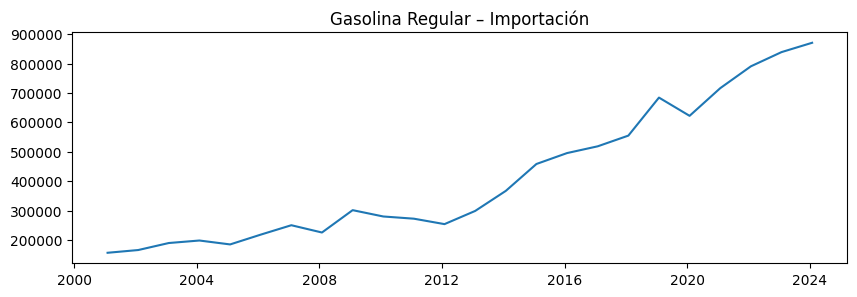

In [29]:
ts_ir = df_imp.set_index('fecha')['gasolina regular'] \
           .resample('M').mean().dropna()

print(f"Regular_imp — Inicio: {ts_ir.index.min().date()}, Fin: {ts_ir.index.max().date()}, Frecuencia: Mensual")

plt.figure(figsize=(10,3))
plt.plot(ts_ir, color='tab:blue')
plt.title('Gasolina Regular – Importación')
plt.show()

values_ir = ts_ir.values

### Gasolina Regular Consumos

Regular_cons — Inicio: 2000-01-31, Fin: 2024-01-31, Frecuencia: Mensual


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_95359/375153888.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M').mean().dropna()


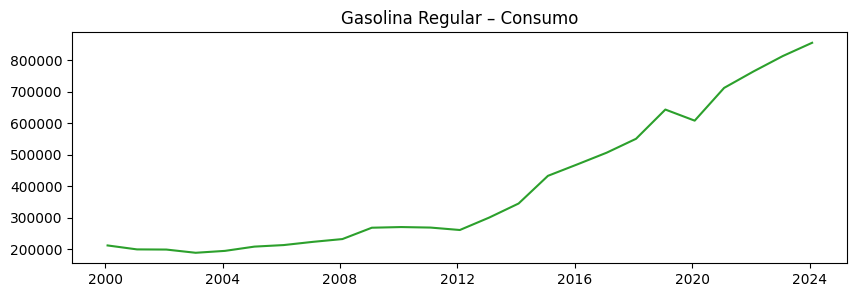

In [30]:
ts_cr = df_cons.set_index('fecha')['gasolina regular'] \
           .resample('M').mean().dropna()

print(f"Regular_cons — Inicio: {ts_cr.index.min().date()}, Fin: {ts_cr.index.max().date()}, Frecuencia: Mensual")

plt.figure(figsize=(10,3))
plt.plot(ts_cr, color='tab:green')
plt.title('Gasolina Regular – Consumo')
plt.show()

values_cr = ts_cr.values

### Gasolina Superior Importaciones

Superior_imp — Inicio: 2001-01-31, Fin: 2024-01-31, Frecuencia: Mensual


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_95359/1285877573.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M').mean().dropna()


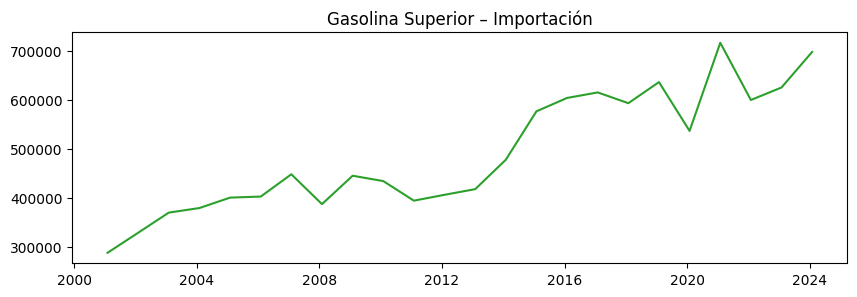

In [31]:
ts_cr = df_imp.set_index('fecha')['gasolina superior'] \
           .resample('M').mean().dropna()

print(f"Superior_imp — Inicio: {ts_cr.index.min().date()}, Fin: {ts_cr.index.max().date()}, Frecuencia: Mensual")

plt.figure(figsize=(10,3))
plt.plot(ts_cr, color='tab:green')
plt.title('Gasolina Superior – Importación')
plt.show()

values_cr = ts_cr.values

### Diesel Importacion

/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_95359/2453093283.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M').mean().dropna()


Diesel_imp — Inicio: 2001-01-31, Fin: 2024-01-31, Frecuencia: Mensual


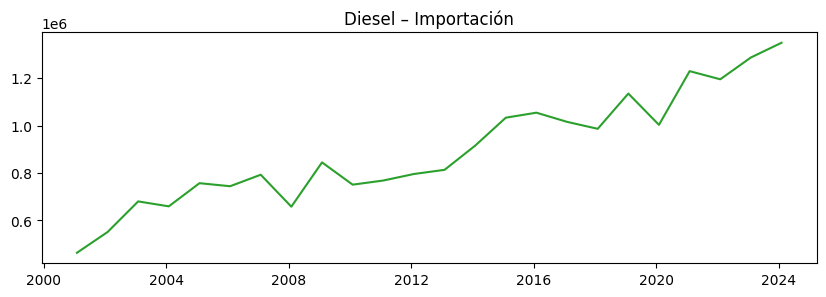

In [32]:
ts_cr = df_imp.set_index('fecha')['diesel'] \
           .resample('M').mean().dropna()

print(f"Diesel_imp — Inicio: {ts_cr.index.min().date()}, Fin: {ts_cr.index.max().date()}, Frecuencia: Mensual")

plt.figure(figsize=(10,3))
plt.plot(ts_cr, color='tab:green')
plt.title('Diesel – Importación')
plt.show()

values_cr = ts_cr.values

### Gasolina Superior Consumo

/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_95359/1101280297.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M').mean().dropna()


Superior_cons — Inicio: 2000-01-31, Fin: 2024-01-31, Frecuencia: Mensual


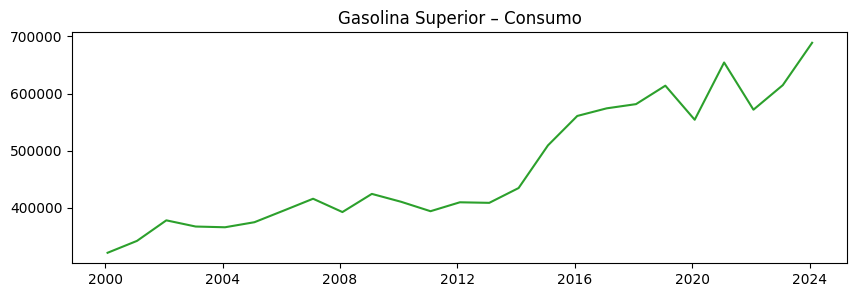

In [33]:
ts_cr = df_cons.set_index('fecha')['gasolina superior'] \
           .resample('M').mean().dropna()

print(f"Superior_cons — Inicio: {ts_cr.index.min().date()}, Fin: {ts_cr.index.max().date()}, Frecuencia: Mensual")

plt.figure(figsize=(10,3))
plt.plot(ts_cr, color='tab:green')
plt.title('Gasolina Superior – Consumo')
plt.show()

values_cr = ts_cr.values

### Diesel Consumo

/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_95359/3015851994.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M').mean().dropna()


Diesel_cons — Inicio: 2000-01-31, Fin: 2024-01-31, Frecuencia: Mensual


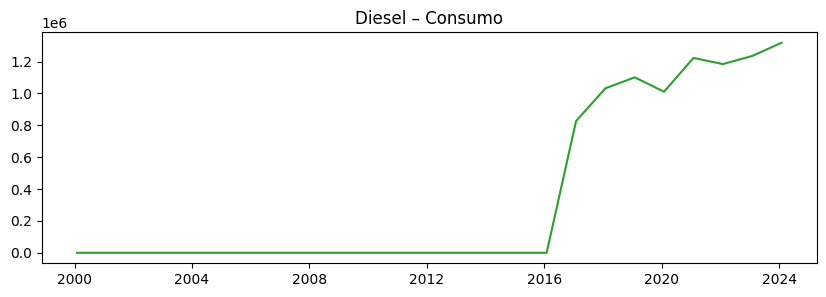

In [34]:
ts_cr = df_cons.set_index('fecha')['diesel bajo azufre'] \
           .resample('M').mean().dropna()

print(f"Diesel_cons — Inicio: {ts_cr.index.min().date()}, Fin: {ts_cr.index.max().date()}, Frecuencia: Mensual")

plt.figure(figsize=(10,3))
plt.plot(ts_cr, color='tab:green')
plt.title('Diesel – Consumo')
plt.show()

values_cr = ts_cr.values

### Preparación de Datos - Gasolina Regular Importaciones

In [35]:
# Crear dataset para Gasolina Regular Importaciones
X_ir, y_ir = create_dataset(values_ir, window_size)
print(f"IR → X_ir: {X_ir.shape}, y_ir: {y_ir.shape}")

# División train/test para IR
train_end = '2023-12-31'
test_start = '2024-01-31'

train_ts_ir = ts_ir[:train_end]
test_ts_ir = ts_ir[test_start:]

print(f"Train IR tiene {len(train_ts_ir)} puntos, Test IR tiene {len(test_ts_ir)}")
print(f"IR train rango: {train_ts_ir.index[0].date()} – {train_ts_ir.index[-1].date()}")

# Recrear dataset con datos de entrenamiento únicamente
X_ir, y_ir = create_dataset(train_ts_ir.values, window_size)
print(f"Después de split y ventanas → IR: X={X_ir.shape}, y={y_ir.shape}")

IR → X_ir: (21, 3, 1), y_ir: (21, 1)
Train IR tiene 23 puntos, Test IR tiene 1
IR train rango: 2001-01-31 – 2023-01-31
Después de split y ventanas → IR: X=(20, 3, 1), y=(20, 1)


### Preparación de Datos - Gasolina Regular Consumos

In [36]:
# Crear dataset para Gasolina Regular Consumos
X_cr, y_cr = create_dataset(values_cr, window_size)
print(f"CR → X_cr: {X_cr.shape}, y_cr: {y_cr.shape}")

# División train/test para CR
train_ts_cr = ts_cr[:train_end]
test_ts_cr = ts_cr[test_start:]

print(f"Train CR tiene {len(train_ts_cr)} puntos, Test CR tiene {len(test_ts_cr)}")
print(f"CR train rango: {train_ts_cr.index[0].date()} – {train_ts_cr.index[-1].date()}")

# Recrear dataset con datos de entrenamiento únicamente
X_cr, y_cr = create_dataset(train_ts_cr.values, window_size)
print(f"Después de split y ventanas → CR: X={X_cr.shape}, y={y_cr.shape}")

CR → X_cr: (22, 3, 1), y_cr: (22, 1)
Train CR tiene 24 puntos, Test CR tiene 1
CR train rango: 2000-01-31 – 2023-01-31
Después de split y ventanas → CR: X=(21, 3, 1), y=(21, 1)


## Entrenamiento LSTM - Gasolina Regular Importaciones

/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Usando dispositivo: cpu
Entrenando modelo para Gasolina Regular Importaciones...
Epoch 10, Loss: 224719808102.399994
Epoch 20, Loss: 224719601664.000000
Epoch 30, Loss: 224719421440.000000
Epoch 40, Loss: 224719208448.000000
Epoch 50, Loss: 224719011840.000000


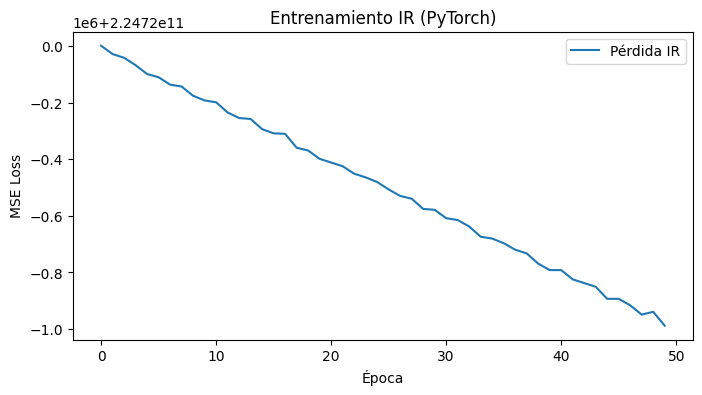

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Preparar datos para PyTorch - IR
tensor_X_ir = torch.tensor(X_ir, dtype=torch.float32).to(device)
tensor_y_ir = torch.tensor(y_ir, dtype=torch.float32).to(device)

batch_size = 8
loader_ir = DataLoader(TensorDataset(tensor_X_ir, tensor_y_ir),
                       batch_size=batch_size, shuffle=True)

# Definir modelo LSTM
class LSTMModel(nn.Module):
    def __init__(self, hidden_size, dropout):
        super().__init__()
        self.lstm = nn.LSTM(1, hidden_size, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.linear(out[:, -1, :])

# Crear modelo y optimizador para IR
model_ir = LSTMModel(hidden_size=32, dropout=0.2).to(device)
criterion = nn.MSELoss()
opt_ir = torch.optim.Adam(model_ir.parameters(), lr=1e-3)

# Función de entrenamiento
def train_model(model, optimizer, loader, epochs=50):
    model.train()
    history = []
    for epoch in range(1, epochs+1):
        epoch_loss = 0.0
        for xb, yb in loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        avg = epoch_loss / len(loader.dataset)
        history.append(avg)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {avg:.6f}")
    return history

# Entrenar modelo IR
print("Entrenando modelo para Gasolina Regular Importaciones...")
history_ir = train_model(model_ir, opt_ir, loader_ir, epochs=50)

# Visualizar pérdida
plt.figure(figsize=(8,4))
plt.plot(history_ir, label='Pérdida IR')
plt.title('Entrenamiento IR (PyTorch)')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### Hyperparameter Tuning - IR

In [38]:

# Parámetros a probar para IR
hidden_sizes = [16, 32, 64]
dropouts = [0.1, 0.2, 0.3]
lrs = [1e-3, 1e-4]
epochs_tune = 20

def tune_lstm_ir(hidden_size, dropout, lr):
    """Función para hacer tuning específico para IR"""
    model = LSTMModel(hidden_size=hidden_size, dropout=dropout).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    
    model.train()
    for _ in range(epochs_tune):
        for xb, yb in loader_ir:
            opt.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            opt.step()
    
    # Evaluar en todo el conjunto
    model.eval()
    with torch.no_grad():
        preds = model(tensor_X_ir)
        final_loss = criterion(preds, tensor_y_ir).item()
    return final_loss

# Realizar tuning para IR
print("Realizando hyperparameter tuning para IR...")
results_ir = []
for hs in hidden_sizes:
    for dp in dropouts:
        for lr in lrs:
            loss = tune_lstm_ir(hs, dp, lr)
            results_ir.append({
                'hidden_size': hs,
                'dropout': dp,
                'lr': lr,
                'loss': loss
            })
            print(f"IR | hs={hs}, dp={dp}, lr={lr} → loss={loss:.2e}")

df_results_ir = pd.DataFrame(results_ir).sort_values('loss')
print("\nMejores hiperparámetros para IR:")
display(df_results_ir.head())

Realizando hyperparameter tuning para IR...
IR | hs=16, dp=0.1, lr=0.001 → loss=2.25e+11


/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


IR | hs=16, dp=0.1, lr=0.0001 → loss=2.25e+11
IR | hs=16, dp=0.2, lr=0.001 → loss=2.25e+11
IR | hs=16, dp=0.2, lr=0.0001 → loss=2.25e+11
IR | hs=16, dp=0.3, lr=0.001 → loss=2.25e+11
IR | hs=16, dp=0.3, lr=0.0001 → loss=2.25e+11


/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


IR | hs=32, dp=0.1, lr=0.001 → loss=2.25e+11
IR | hs=32, dp=0.1, lr=0.0001 → loss=2.25e+11
IR | hs=32, dp=0.2, lr=0.001 → loss=2.25e+11
IR | hs=32, dp=0.2, lr=0.0001 → loss=2.25e+11
IR | hs=32, dp=0.3, lr=0.001 → loss=2.25e+11
IR | hs=32, dp=0.3, lr=0.0001 → loss=2.25e+11
IR | hs=64, dp=0.1, lr=0.001 → loss=2.25e+11
IR | hs=64, dp=0.1, lr=0.0001 → loss=2.25e+11
IR | hs=64, dp=0.2, lr=0.001 → loss=2.25e+11
IR | hs=64, dp=0.2, lr=0.0001 → loss=2.25e+11
IR | hs=64, dp=0.3, lr=0.001 → loss=2.25e+11
IR | hs=64, dp=0.3, lr=0.0001 → loss=2.25e+11

Mejores hiperparámetros para IR:


,hidden_size,dropout,lr,loss
16,64,0.3,0.0010,2.247187e+11
14,64,0.2,0.0010,2.247189e+11
12,64,0.1,0.0010,2.247191e+11
13,64,0.1,0.0001,2.247192e+11
10,32,0.3,0.0010,2.247193e+11


## Entrenamiento LSTM - Gasolina Regular Consumos

Entrenando modelo para Gasolina Regular Consumos...
Epoch 10, Loss: 399998947913.142883
Epoch 20, Loss: 399998829324.190491
Epoch 30, Loss: 399998672505.904785
Epoch 40, Loss: 399998475117.714294
Epoch 50, Loss: 399998253543.619019


/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


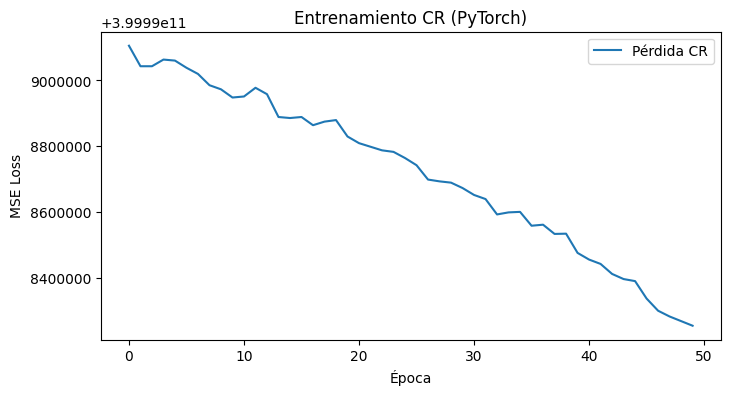

In [39]:
# Preparar datos para PyTorch - CR
tensor_X_cr = torch.tensor(X_cr, dtype=torch.float32).to(device)
tensor_y_cr = torch.tensor(y_cr, dtype=torch.float32).to(device)

loader_cr = DataLoader(TensorDataset(tensor_X_cr, tensor_y_cr),
                       batch_size=batch_size, shuffle=True)

# Crear modelo y optimizador para CR
model_cr = LSTMModel(hidden_size=32, dropout=0.2).to(device)
opt_cr = torch.optim.Adam(model_cr.parameters(), lr=1e-3)

# Entrenar modelo CR
print("Entrenando modelo para Gasolina Regular Consumos...")
history_cr = train_model(model_cr, opt_cr, loader_cr, epochs=50)

# Visualizar pérdida
plt.figure(figsize=(8,4))
plt.plot(history_cr, label='Pérdida CR')
plt.title('Entrenamiento CR (PyTorch)')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### Hyperparameter Tuning - CR

In [40]:
def tune_lstm_cr(hidden_size, dropout, lr):
    """Función para hacer tuning específico para CR"""
    model = LSTMModel(hidden_size=hidden_size, dropout=dropout).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    
    model.train()
    for _ in range(epochs_tune):
        for xb, yb in loader_cr:
            opt.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            opt.step()
    
    # Evaluar en todo el conjunto
    model.eval()
    with torch.no_grad():
        preds = model(tensor_X_cr)
        final_loss = criterion(preds, tensor_y_cr).item()
    return final_loss

# Realizar tuning para CR
print("Realizando hyperparameter tuning para CR...")
results_cr = []
for hs in hidden_sizes:
    for dp in dropouts:
        for lr in lrs:
            loss = tune_lstm_cr(hs, dp, lr)
            results_cr.append({
                'hidden_size': hs,
                'dropout': dp,
                'lr': lr,
                'loss': loss
            })
            print(f"CR | hs={hs}, dp={dp}, lr={lr} → loss={loss:.2e}")

df_results_cr = pd.DataFrame(results_cr).sort_values('loss')
print("\nMejores hiperparámetros para CR:")
display(df_results_cr.head())

Realizando hyperparameter tuning para CR...
CR | hs=16, dp=0.1, lr=0.001 → loss=4.00e+11
CR | hs=16, dp=0.1, lr=0.0001 → loss=4.00e+11
CR | hs=16, dp=0.2, lr=0.001 → loss=4.00e+11
CR | hs=16, dp=0.2, lr=0.0001 → loss=4.00e+11
CR | hs=16, dp=0.3, lr=0.001 → loss=4.00e+11
CR | hs=16, dp=0.3, lr=0.0001 → loss=4.00e+11
CR | hs=32, dp=0.1, lr=0.001 → loss=4.00e+11


/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


CR | hs=32, dp=0.1, lr=0.0001 → loss=4.00e+11
CR | hs=32, dp=0.2, lr=0.001 → loss=4.00e+11
CR | hs=32, dp=0.2, lr=0.0001 → loss=4.00e+11
CR | hs=32, dp=0.3, lr=0.001 → loss=4.00e+11
CR | hs=32, dp=0.3, lr=0.0001 → loss=4.00e+11
CR | hs=64, dp=0.1, lr=0.001 → loss=4.00e+11
CR | hs=64, dp=0.1, lr=0.0001 → loss=4.00e+11
CR | hs=64, dp=0.2, lr=0.001 → loss=4.00e+11
CR | hs=64, dp=0.2, lr=0.0001 → loss=4.00e+11
CR | hs=64, dp=0.3, lr=0.001 → loss=4.00e+11
CR | hs=64, dp=0.3, lr=0.0001 → loss=4.00e+11

Mejores hiperparámetros para CR:


,hidden_size,dropout,lr,loss
16,64,0.3,0.001,3.999982e+11
12,64,0.1,0.001,3.999984e+11
2,16,0.2,0.001,3.999985e+11
6,32,0.1,0.001,3.999986e+11
10,32,0.3,0.001,3.999986e+11


## Entrenamiento LSTM – Gasolina Superior Importaciones

Entrenando LSTM para Gasolina Superior Importaciones…
Epoch 10, Loss: 265613269401.600006
Epoch 20, Loss: 265612984320.000000
Epoch 30, Loss: 265612689408.000000
Epoch 40, Loss: 265612387942.399994
Epoch 50, Loss: 265612106137.600006


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_95359/3737434254.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M').mean().dropna()
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


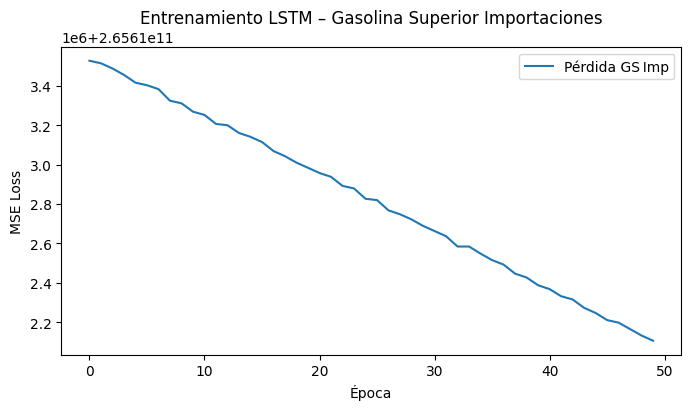

In [41]:
ts_gs_imp = df_imp.set_index('fecha')['gasolina superior'] \
                  .resample('M').mean().dropna()

train_gs_imp = ts_gs_imp[:'2023-12-31']
test_gs_imp  = ts_gs_imp['2024-01-31':]

window_size = 3
X_gs_imp, y_gs_imp = create_dataset(train_gs_imp.values, window_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tensor_X_gs_imp = torch.tensor(X_gs_imp, dtype=torch.float32).to(device)
tensor_y_gs_imp = torch.tensor(y_gs_imp, dtype=torch.float32).to(device)

batch_size = 8
loader_gs_imp = DataLoader(
    TensorDataset(tensor_X_gs_imp, tensor_y_gs_imp),
    batch_size=batch_size,
    shuffle=True
)

model_gs_imp = LSTMModel(hidden_size=32, dropout=0.2).to(device)
criterion    = nn.MSELoss()
opt_gs_imp   = torch.optim.Adam(model_gs_imp.parameters(), lr=1e-3)


def train_model(model, optimizer, loader, epochs=50):
    model.train()
    history = []
    for epoch in range(1, epochs+1):
        epoch_loss = 0.0
        for xb, yb in loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        avg = epoch_loss / len(loader.dataset)
        history.append(avg)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {avg:.6f}")
    return history

print("Entrenando LSTM para Gasolina Superior Importaciones…")
history_gs_imp = train_model(model_gs_imp, opt_gs_imp, loader_gs_imp, epochs=50)

plt.figure(figsize=(8,4))
plt.plot(history_gs_imp, label='Pérdida GS Imp')
plt.title('Entrenamiento LSTM – Gasolina Superior Importaciones')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### Hyperparameter Tuning – Gasolina Superior Importaciones


In [42]:
hidden_sizes = [16, 32, 64]
dropouts     = [0.1, 0.2, 0.3]
lrs          = [1e-3, 1e-4]
epochs_tune  = 20

def tune_lstm_gs_imp(hidden_size, dropout, lr):
    model = LSTMModel(hidden_size=hidden_size, dropout=dropout).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for _ in range(epochs_tune):
        for xb, yb in loader_gs_imp:
            opt.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            opt.step()
    model.eval()
    with torch.no_grad():
        preds = model(tensor_X_gs_imp)
        return criterion(preds, tensor_y_gs_imp).item()

print("Realizando hyperparameter tuning para GS Importaciones…")
results_gs_imp = []
for hs in hidden_sizes:
    for dp in dropouts:
        for lr in lrs:
            loss = tune_lstm_gs_imp(hs, dp, lr)
            results_gs_imp.append({
                'hidden_size': hs,
                'dropout': dp,
                'lr': lr,
                'loss': loss
            })
            print(f"GS Imp | hs={hs}, dp={dp}, lr={lr} → loss={loss:.2e}")

df_results_gs_imp = pd.DataFrame(results_gs_imp).sort_values('loss')
print("\nMejores hiperparámetros para GS Importaciones:")
display(df_results_gs_imp.head())

Realizando hyperparameter tuning para GS Importaciones…


/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


GS Imp | hs=16, dp=0.1, lr=0.001 → loss=2.66e+11
GS Imp | hs=16, dp=0.1, lr=0.0001 → loss=2.66e+11
GS Imp | hs=16, dp=0.2, lr=0.001 → loss=2.66e+11
GS Imp | hs=16, dp=0.2, lr=0.0001 → loss=2.66e+11
GS Imp | hs=16, dp=0.3, lr=0.001 → loss=2.66e+11
GS Imp | hs=16, dp=0.3, lr=0.0001 → loss=2.66e+11
GS Imp | hs=32, dp=0.1, lr=0.001 → loss=2.66e+11


/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


GS Imp | hs=32, dp=0.1, lr=0.0001 → loss=2.66e+11
GS Imp | hs=32, dp=0.2, lr=0.001 → loss=2.66e+11
GS Imp | hs=32, dp=0.2, lr=0.0001 → loss=2.66e+11
GS Imp | hs=32, dp=0.3, lr=0.001 → loss=2.66e+11
GS Imp | hs=32, dp=0.3, lr=0.0001 → loss=2.66e+11
GS Imp | hs=64, dp=0.1, lr=0.001 → loss=2.66e+11
GS Imp | hs=64, dp=0.1, lr=0.0001 → loss=2.66e+11
GS Imp | hs=64, dp=0.2, lr=0.001 → loss=2.66e+11
GS Imp | hs=64, dp=0.2, lr=0.0001 → loss=2.66e+11
GS Imp | hs=64, dp=0.3, lr=0.001 → loss=2.66e+11
GS Imp | hs=64, dp=0.3, lr=0.0001 → loss=2.66e+11

Mejores hiperparámetros para GS Importaciones:


,hidden_size,dropout,lr,loss
16,64,0.3,0.001,2.656124e+11
14,64,0.2,0.001,2.656124e+11
12,64,0.1,0.001,2.656126e+11
4,16,0.3,0.001,2.656126e+11
10,32,0.3,0.001,2.656126e+11


## Entrenamiento LSTM – Diésel Importaciones

Entrenando LSTM para Diésel Importaciones…
Epoch 10, Loss: 884736498073.599976
Epoch 20, Loss: 884735921356.800049
Epoch 30, Loss: 884735344640.000000
Epoch 40, Loss: 884734702387.199951
Epoch 50, Loss: 884734007705.599976


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_95359/104137468.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M').mean().dropna()
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


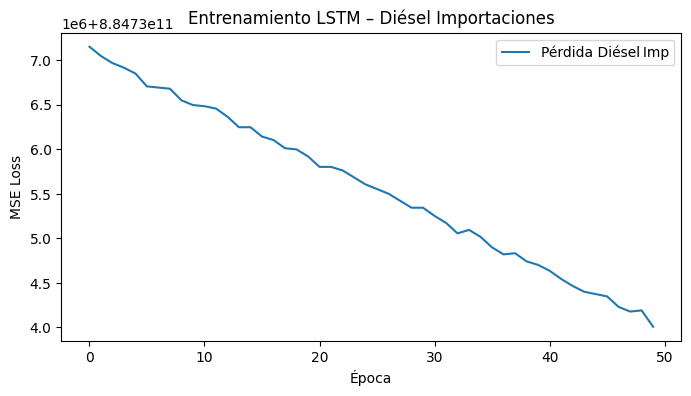

In [43]:
ts_di_imp = df_imp.set_index('fecha')['diesel'] \
                  .resample('M').mean().dropna()

train_di_imp = ts_di_imp[:'2023-12-31']
test_di_imp  = ts_di_imp['2024-01-31':]

window_size = 3
X_di_imp, y_di_imp = create_dataset(train_di_imp.values, window_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tensor_X_di_imp = torch.tensor(X_di_imp, dtype=torch.float32).to(device)
tensor_y_di_imp = torch.tensor(y_di_imp, dtype=torch.float32).to(device)

batch_size = 8
loader_di_imp = DataLoader(
    TensorDataset(tensor_X_di_imp, tensor_y_di_imp),
    batch_size=batch_size,
    shuffle=True
)

model_di_imp = LSTMModel(hidden_size=32, dropout=0.2).to(device)
criterion    = nn.MSELoss()
opt_di_imp   = torch.optim.Adam(model_di_imp.parameters(), lr=1e-3)

def train_model(model, optimizer, loader, epochs=50):
    model.train()
    history = []
    for epoch in range(1, epochs+1):
        epoch_loss = 0.0
        for xb, yb in loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        avg = epoch_loss / len(loader.dataset)
        history.append(avg)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {avg:.6f}")
    return history

print("Entrenando LSTM para Diésel Importaciones…")
history_di_imp = train_model(model_di_imp, opt_di_imp, loader_di_imp, epochs=50)

plt.figure(figsize=(8,4))
plt.plot(history_di_imp, label='Pérdida Diésel Imp')
plt.title('Entrenamiento LSTM – Diésel Importaciones')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### Hyperparameter Tuning – Diésel Importaciones

In [44]:
hidden_sizes = [16, 32, 64]
dropouts     = [0.1, 0.2, 0.3]
lrs          = [1e-3, 1e-4]
epochs_tune  = 20

def tune_lstm_di_imp(hidden_size, dropout, lr):
    model = LSTMModel(hidden_size=hidden_size, dropout=dropout).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for _ in range(epochs_tune):
        for xb, yb in loader_di_imp:
            opt.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            opt.step()
    model.eval()
    with torch.no_grad():
        preds = model(tensor_X_di_imp)
        return criterion(preds, tensor_y_di_imp).item()

print("Realizando hyperparameter tuning para Diésel Importaciones…")
results_di_imp = []
for hs in hidden_sizes:
    for dp in dropouts:
        for lr in lrs:
            loss = tune_lstm_di_imp(hs, dp, lr)
            results_di_imp.append({
                'hidden_size': hs,
                'dropout': dp,
                'lr': lr,
                'loss': loss
            })
            print(f"Diésel Imp | hs={hs}, dp={dp}, lr={lr} → loss={loss:.2e}")

df_results_di_imp = pd.DataFrame(results_di_imp).sort_values('loss')
print("\nMejores hiperparámetros para Diésel Importaciones:")
display(df_results_di_imp.head())

Realizando hyperparameter tuning para Diésel Importaciones…
Diésel Imp | hs=16, dp=0.1, lr=0.001 → loss=8.85e+11
Diésel Imp | hs=16, dp=0.1, lr=0.0001 → loss=8.85e+11


/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Diésel Imp | hs=16, dp=0.2, lr=0.001 → loss=8.85e+11
Diésel Imp | hs=16, dp=0.2, lr=0.0001 → loss=8.85e+11
Diésel Imp | hs=16, dp=0.3, lr=0.001 → loss=8.85e+11
Diésel Imp | hs=16, dp=0.3, lr=0.0001 → loss=8.85e+11
Diésel Imp | hs=32, dp=0.1, lr=0.001 → loss=8.85e+11


/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Diésel Imp | hs=32, dp=0.1, lr=0.0001 → loss=8.85e+11
Diésel Imp | hs=32, dp=0.2, lr=0.001 → loss=8.85e+11
Diésel Imp | hs=32, dp=0.2, lr=0.0001 → loss=8.85e+11
Diésel Imp | hs=32, dp=0.3, lr=0.001 → loss=8.85e+11
Diésel Imp | hs=32, dp=0.3, lr=0.0001 → loss=8.85e+11
Diésel Imp | hs=64, dp=0.1, lr=0.001 → loss=8.85e+11
Diésel Imp | hs=64, dp=0.1, lr=0.0001 → loss=8.85e+11
Diésel Imp | hs=64, dp=0.2, lr=0.001 → loss=8.85e+11
Diésel Imp | hs=64, dp=0.2, lr=0.0001 → loss=8.85e+11
Diésel Imp | hs=64, dp=0.3, lr=0.001 → loss=8.85e+11
Diésel Imp | hs=64, dp=0.3, lr=0.0001 → loss=8.85e+11

Mejores hiperparámetros para Diésel Importaciones:


,hidden_size,dropout,lr,loss
16,64,0.3,0.001,8.847337e+11
14,64,0.2,0.001,8.847342e+11
8,32,0.2,0.001,8.847348e+11
4,16,0.3,0.001,8.847348e+11
12,64,0.1,0.001,8.847350e+11


## Entrenamiento LSTM – Gasolina Superior Consumo

Entrenando LSTM para Gasolina Superior Consumo…
Epoch 10, Loss: 237013130873.904755
Epoch 20, Loss: 237013008384.000000
Epoch 30, Loss: 237012902278.095245
Epoch 40, Loss: 237012786809.904755
Epoch 50, Loss: 237012668220.952393


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_95359/1589451634.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M').mean().dropna()
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


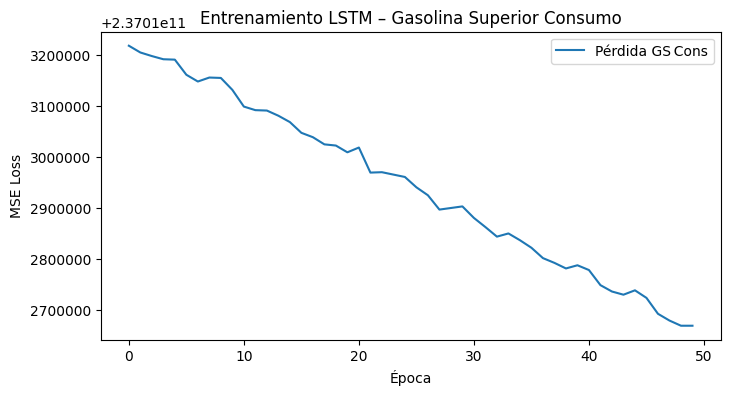

In [45]:
ts_gs_cons = df_cons.set_index('fecha')['gasolina superior'] \
                   .resample('M').mean().dropna()

train_gs_cons = ts_gs_cons[:'2023-12-31']
test_gs_cons  = ts_gs_cons['2024-01-31':]

window_size = 3
X_gs_cons, y_gs_cons = create_dataset(train_gs_cons.values, window_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tensor_X_gs_cons = torch.tensor(X_gs_cons, dtype=torch.float32).to(device)
tensor_y_gs_cons = torch.tensor(y_gs_cons, dtype=torch.float32).to(device)

batch_size = 8
loader_gs_cons = DataLoader(
    TensorDataset(tensor_X_gs_cons, tensor_y_gs_cons),
    batch_size=batch_size,
    shuffle=True
)

model_gs_cons = LSTMModel(hidden_size=32, dropout=0.2).to(device)
criterion     = nn.MSELoss()
opt_gs_cons   = torch.optim.Adam(model_gs_cons.parameters(), lr=1e-3)

def train_model(model, optimizer, loader, epochs=50):
    model.train()
    history = []
    for epoch in range(1, epochs+1):
        epoch_loss = 0.0
        for xb, yb in loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        avg = epoch_loss / len(loader.dataset)
        history.append(avg)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {avg:.6f}")
    return history

print("Entrenando LSTM para Gasolina Superior Consumo…")
history_gs_cons = train_model(model_gs_cons, opt_gs_cons, loader_gs_cons, epochs=50)

plt.figure(figsize=(8,4))
plt.plot(history_gs_cons, label='Pérdida GS Cons')
plt.title('Entrenamiento LSTM – Gasolina Superior Consumo')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### Hyperparameter Tuning – Gasolina Superior Consumo

In [46]:
hidden_sizes = [16, 32, 64]
dropouts     = [0.1, 0.2, 0.3]
lrs          = [1e-3, 1e-4]
epochs_tune  = 20

def tune_lstm_gs_cons(hidden_size, dropout, lr):
    model = LSTMModel(hidden_size=hidden_size, dropout=dropout).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for _ in range(epochs_tune):
        for xb, yb in loader_gs_cons:
            opt.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            opt.step()
    model.eval()
    with torch.no_grad():
        preds = model(tensor_X_gs_cons)
        return criterion(preds, tensor_y_gs_cons).item()

print("Realizando hyperparameter tuning para GS Consumo…")
results_gs_cons = []
for hs in hidden_sizes:
    for dp in dropouts:
        for lr in lrs:
            loss = tune_lstm_gs_cons(hs, dp, lr)
            results_gs_cons.append({
                'hidden_size': hs,
                'dropout': dp,
                'lr': lr,
                'loss': loss
            })
            print(f"GS Cons | hs={hs}, dp={dp}, lr={lr} → loss={loss:.2e}")

df_results_gs_cons = pd.DataFrame(results_gs_cons).sort_values('loss')
print("\nMejores hiperparámetros para GS Consumo:")
display(df_results_gs_cons.head())

Realizando hyperparameter tuning para GS Consumo…


/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


GS Cons | hs=16, dp=0.1, lr=0.001 → loss=2.37e+11
GS Cons | hs=16, dp=0.1, lr=0.0001 → loss=2.37e+11
GS Cons | hs=16, dp=0.2, lr=0.001 → loss=2.37e+11
GS Cons | hs=16, dp=0.2, lr=0.0001 → loss=2.37e+11
GS Cons | hs=16, dp=0.3, lr=0.001 → loss=2.37e+11
GS Cons | hs=16, dp=0.3, lr=0.0001 → loss=2.37e+11
GS Cons | hs=32, dp=0.1, lr=0.001 → loss=2.37e+11


/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


GS Cons | hs=32, dp=0.1, lr=0.0001 → loss=2.37e+11
GS Cons | hs=32, dp=0.2, lr=0.001 → loss=2.37e+11
GS Cons | hs=32, dp=0.2, lr=0.0001 → loss=2.37e+11
GS Cons | hs=32, dp=0.3, lr=0.001 → loss=2.37e+11
GS Cons | hs=32, dp=0.3, lr=0.0001 → loss=2.37e+11
GS Cons | hs=64, dp=0.1, lr=0.001 → loss=2.37e+11
GS Cons | hs=64, dp=0.1, lr=0.0001 → loss=2.37e+11
GS Cons | hs=64, dp=0.2, lr=0.001 → loss=2.37e+11
GS Cons | hs=64, dp=0.2, lr=0.0001 → loss=2.37e+11
GS Cons | hs=64, dp=0.3, lr=0.001 → loss=2.37e+11
GS Cons | hs=64, dp=0.3, lr=0.0001 → loss=2.37e+11

Mejores hiperparámetros para GS Consumo:


,hidden_size,dropout,lr,loss
14,64,0.2,0.001,2.370121e+11
12,64,0.1,0.001,2.370122e+11
6,32,0.1,0.001,2.370126e+11
0,16,0.1,0.001,2.370128e+11
10,32,0.3,0.001,2.370128e+11


## Entrenamiento LSTM – Diésel Bajo Azufre Consumo

Entrenando LSTM para Diésel Bajo Azufre Consumo…
Epoch 10, Loss: 399999077424.761902
Epoch 20, Loss: 399998960396.190491
Epoch 30, Loss: 399998799676.952393
Epoch 40, Loss: 399998648320.000000
Epoch 50, Loss: 399998425185.523804


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_95359/3314449878.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M').mean().dropna()
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


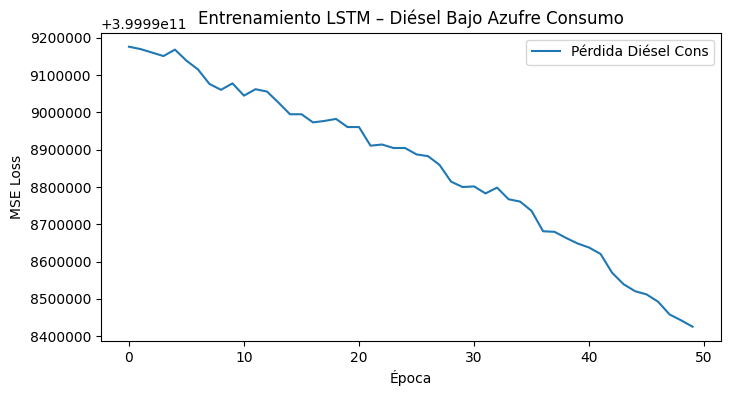

In [47]:
ts_di_cons = df_cons.set_index('fecha')['diesel bajo azufre'] \
                   .resample('M').mean().dropna()

train_di_cons = ts_di_cons[:'2023-12-31']
test_di_cons  = ts_di_cons['2024-01-31':]

window_size = 3
X_di_cons, y_di_cons = create_dataset(train_di_cons.values, window_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tensor_X_di_cons = torch.tensor(X_di_cons, dtype=torch.float32).to(device)
tensor_y_di_cons = torch.tensor(y_di_cons, dtype=torch.float32).to(device)

batch_size = 8
loader_di_cons = DataLoader(
    TensorDataset(tensor_X_di_cons, tensor_y_di_cons),
    batch_size=batch_size,
    shuffle=True
)

model_di_cons = LSTMModel(hidden_size=32, dropout=0.2).to(device)
criterion     = nn.MSELoss()
opt_di_cons   = torch.optim.Adam(model_di_cons.parameters(), lr=1e-3)

def train_model(model, optimizer, loader, epochs=50):
    model.train()
    history = []
    for epoch in range(1, epochs+1):
        epoch_loss = 0.0
        for xb, yb in loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        avg = epoch_loss / len(loader.dataset)
        history.append(avg)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {avg:.6f}")
    return history

print("Entrenando LSTM para Diésel Bajo Azufre Consumo…")
history_di_cons = train_model(model_di_cons, opt_di_cons, loader_di_cons, epochs=50)

plt.figure(figsize=(8,4))
plt.plot(history_di_cons, label='Pérdida Diésel Cons')
plt.title('Entrenamiento LSTM – Diésel Bajo Azufre Consumo')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [48]:
hidden_sizes = [16, 32, 64]
dropouts     = [0.1, 0.2, 0.3]
lrs          = [1e-3, 1e-4]
epochs_tune  = 20

def tune_lstm_di_cons(hidden_size, dropout, lr):
    model = LSTMModel(hidden_size=hidden_size, dropout=dropout).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for _ in range(epochs_tune):
        for xb, yb in loader_di_cons:
            opt.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            opt.step()
    model.eval()
    with torch.no_grad():
        preds = model(tensor_X_di_cons)
        return criterion(preds, tensor_y_di_cons).item()

print("Realizando hyperparameter tuning para Diésel Bajo Azufre Consumo…")
results_di_cons = []
for hs in hidden_sizes:
    for dp in dropouts:
        for lr in lrs:
            loss = tune_lstm_di_cons(hs, dp, lr)
            results_di_cons.append({
                'hidden_size': hs,
                'dropout': dp,
                'lr': lr,
                'loss': loss
            })
            print(f"Diésel Cons | hs={hs}, dp={dp}, lr={lr} → loss={loss:.2e}")

df_results_di_cons = pd.DataFrame(results_di_cons).sort_values('loss')
print("\nMejores hiperparámetros para Diésel Bajo Azufre Consumo:")
display(df_results_di_cons.head())

Realizando hyperparameter tuning para Diésel Bajo Azufre Consumo…
Diésel Cons | hs=16, dp=0.1, lr=0.001 → loss=4.00e+11


/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Diésel Cons | hs=16, dp=0.1, lr=0.0001 → loss=4.00e+11
Diésel Cons | hs=16, dp=0.2, lr=0.001 → loss=4.00e+11
Diésel Cons | hs=16, dp=0.2, lr=0.0001 → loss=4.00e+11
Diésel Cons | hs=16, dp=0.3, lr=0.001 → loss=4.00e+11
Diésel Cons | hs=16, dp=0.3, lr=0.0001 → loss=4.00e+11
Diésel Cons | hs=32, dp=0.1, lr=0.001 → loss=4.00e+11


/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Diésel Cons | hs=32, dp=0.1, lr=0.0001 → loss=4.00e+11
Diésel Cons | hs=32, dp=0.2, lr=0.001 → loss=4.00e+11
Diésel Cons | hs=32, dp=0.2, lr=0.0001 → loss=4.00e+11
Diésel Cons | hs=32, dp=0.3, lr=0.001 → loss=4.00e+11
Diésel Cons | hs=32, dp=0.3, lr=0.0001 → loss=4.00e+11
Diésel Cons | hs=64, dp=0.1, lr=0.001 → loss=4.00e+11
Diésel Cons | hs=64, dp=0.1, lr=0.0001 → loss=4.00e+11
Diésel Cons | hs=64, dp=0.2, lr=0.001 → loss=4.00e+11
Diésel Cons | hs=64, dp=0.2, lr=0.0001 → loss=4.00e+11
Diésel Cons | hs=64, dp=0.3, lr=0.001 → loss=4.00e+11
Diésel Cons | hs=64, dp=0.3, lr=0.0001 → loss=4.00e+11

Mejores hiperparámetros para Diésel Bajo Azufre Consumo:


,hidden_size,dropout,lr,loss
1,16,0.1,0.0001,3.999986e+11
14,64,0.2,0.0010,3.999986e+11
16,64,0.3,0.0010,3.999986e+11
8,32,0.2,0.0010,3.999986e+11
11,32,0.3,0.0001,3.999987e+11


## Modelos Finales y Predicciones

Entrenando modelo final IR...
Epoch 10, Loss: 224719437824.000000
Epoch 20, Loss: 224719267430.399994
Epoch 30, Loss: 224719097036.799988
Epoch 40, Loss: 224718913536.000000
Epoch 50, Loss: 224718736588.799988
Entrenando modelo final CR...
Epoch 10, Loss: 399998765348.571411
Epoch 20, Loss: 399998698252.190491
Epoch 30, Loss: 399998629595.428589
Epoch 40, Loss: 399998564059.641113
Epoch 50, Loss: 399998445470.476196


/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


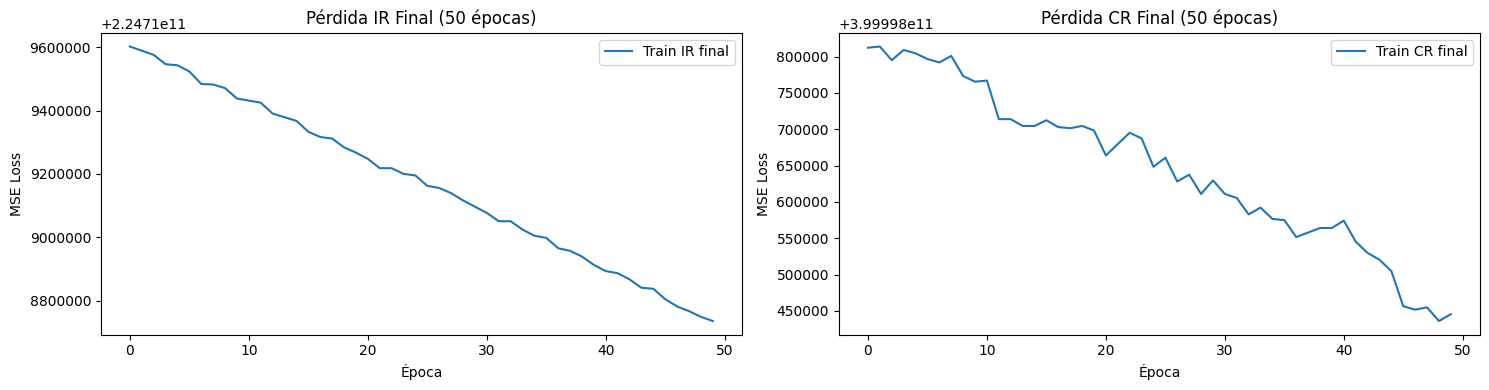

In [49]:
from sklearn.preprocessing import MinMaxScaler

# Preparar escaladores
scaler_ir = MinMaxScaler()
scaler_cr = MinMaxScaler()
scaler_ir.fit(train_ts_ir.values.reshape(-1, 1))
scaler_cr.fit(train_ts_cr.values.reshape(-1, 1))

model_ir_final = LSTMModel(hidden_size=32, dropout=0.1).to(device)
opt_ir_final = torch.optim.Adam(model_ir_final.parameters(), lr=1e-3)

model_cr_final = LSTMModel(hidden_size=16, dropout=0.2).to(device)
opt_cr_final = torch.optim.Adam(model_cr_final.parameters(), lr=1e-3)

print("Entrenando modelo final IR...")
history_ir_final = train_model(model_ir_final, opt_ir_final, loader_ir, epochs=50)

print("Entrenando modelo final CR...")
history_cr_final = train_model(model_cr_final, opt_cr_final, loader_cr, epochs=50)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

ax1.plot(history_ir_final, label='Train IR final')
ax1.set_title('Pérdida IR Final (50 épocas)')
ax1.set_xlabel('Época')
ax1.set_ylabel('MSE Loss')
ax1.legend()

ax2.plot(history_cr_final, label='Train CR final')
ax2.set_title('Pérdida CR Final (50 épocas)')
ax2.set_xlabel('Época')
ax2.set_ylabel('MSE Loss')
ax2.legend()

plt.tight_layout()
plt.show()

### Gasolina Regular

In [50]:
### Predicciones para Enero 2024

model_ir_final.eval()
model_cr_final.eval()

last_window_ir = torch.tensor(train_ts_ir.values[-3:].reshape(1, 3, 1),
                              dtype=torch.float32).to(device)
with torch.no_grad():
    pred_ir = model_ir_final(last_window_ir).item()

pred_ir_value = pred_ir

last_window_cr = torch.tensor(train_ts_cr.values[-3:].reshape(1, 3, 1),
                              dtype=torch.float32).to(device)
with torch.no_grad():
    pred_cr = model_cr_final(last_window_cr).item()

pred_cr_value = pred_cr

print("=== PREDICCIONES PARA ENERO 2024 ===")
print(f"Predicción IR (Importaciones): {pred_ir_value:.2f}")
print(f"Verdadero   IR (Importaciones): {test_ts_ir.iloc[0]:.2f}")
print(f"Error IR: {abs(pred_ir_value - test_ts_ir.iloc[0]):.2f}")
print()
print(f"Predicción CR (Consumos): {pred_cr_value:.2f}")
print(f"Verdadero   CR (Consumos): {test_ts_cr.iloc[0]:.2f}")
print(f"Error CR: {abs(pred_cr_value - test_ts_cr.iloc[0]):.2f}")

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_ir = mean_absolute_error([test_ts_ir.iloc[0]], [pred_ir_value])
mse_ir = mean_squared_error([test_ts_ir.iloc[0]], [pred_ir_value])
mae_cr = mean_absolute_error([test_ts_cr.iloc[0]], [pred_cr_value])
mse_cr = mean_squared_error([test_ts_cr.iloc[0]], [pred_cr_value])

print("\n=== MÉTRICAS DE ERROR ===")
print(f"IR - MAE: {mae_ir:.2f}, MSE: {mse_ir:.2f}, RMSE: {mse_ir**0.5:.2f}")
print(f"CR - MAE: {mae_cr:.2f}, MSE: {mse_cr:.2f}, RMSE: {mse_cr**0.5:.2f}")

=== PREDICCIONES PARA ENERO 2024 ===
Predicción IR (Importaciones): 1.26
Verdadero   IR (Importaciones): 870465.31
Error IR: 870464.05

Predicción CR (Consumos): 0.73
Verdadero   CR (Consumos): 1317556.51
Error CR: 1317555.78

=== MÉTRICAS DE ERROR ===
IR - MAE: 870464.05, MSE: 757707665904.24, RMSE: 870464.05
CR - MAE: 1317555.78, MSE: 1735953235799.22, RMSE: 1317555.78


### Gasolina Superior

In [51]:
# Usar hiperparámetros óptimos del tuning anterior
best_params_gs_cons = df_results_gs_cons.iloc[0]
model_gs_cons_final = LSTMModel(
    hidden_size=int(best_params_gs_cons['hidden_size']),
    dropout=float(best_params_gs_cons['dropout'])
).to(device)

opt_gs_cons_final = torch.optim.Adam(
    model_gs_cons_final.parameters(),
    lr=float(best_params_gs_cons['lr'])
)

# Entrenar modelo final
print("Entrenando modelo final – Gasolina Superior Consumo...")
history_gs_cons_final = train_model(model_gs_cons_final, opt_gs_cons_final, loader_gs_cons, epochs=50)

# Predicción Enero 2024
model_gs_cons_final.eval()
last_window_gs_cons = torch.tensor(train_gs_cons.values[-3:].reshape(1, 3, 1), dtype=torch.float32).to(device)

with torch.no_grad():
    pred_gs_cons = model_gs_cons_final(last_window_gs_cons).item()

real_gs_cons = test_gs_cons.iloc[0]
error_gs_cons = abs(pred_gs_cons - real_gs_cons)

print(f"\n📍 Predicción Gasolina Superior Consumo – Enero 2024:")
print(f"→ Predicho: {pred_gs_cons:.2f}")
print(f"→ Real:     {real_gs_cons:.2f}")
print(f"→ Error Absoluto: {error_gs_cons:.2f}")

# Métricas
mae = mean_absolute_error([real_gs_cons], [pred_gs_cons])
mse = mean_squared_error([real_gs_cons], [pred_gs_cons])
rmse = mse ** 0.5

print(f"\n📊 Métricas GS Consumo – Enero 2024")
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")


Entrenando modelo final – Gasolina Superior Consumo...
Epoch 10, Loss: 237012779008.000000
Epoch 20, Loss: 237012368627.809509
Epoch 30, Loss: 237011955126.857147
Epoch 40, Loss: 237011529923.047607
Epoch 50, Loss: 237011118762.666656

📍 Predicción Gasolina Superior Consumo – Enero 2024:
→ Predicho: 2.21
→ Real:     688994.82
→ Error Absoluto: 688992.60

📊 Métricas GS Consumo – Enero 2024
MAE:  688992.60
MSE:  474710807761.83
RMSE: 688992.60


/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [52]:
# Usar hiperparámetros óptimos del tuning anterior
best_params_gs_imp = df_results_gs_imp.iloc[0]
model_gs_imp_final = LSTMModel(
    hidden_size=int(best_params_gs_imp['hidden_size']),
    dropout=float(best_params_gs_imp['dropout'])
).to(device)

opt_gs_imp_final = torch.optim.Adam(
    model_gs_imp_final.parameters(),
    lr=float(best_params_gs_imp['lr'])
)

# Entrenar modelo final
print("Entrenando modelo final – Gasolina Superior Importación...")
history_gs_imp_final = train_model(model_gs_imp_final, opt_gs_imp_final, loader_gs_imp, epochs=50)

# Predicción Enero 2024
model_gs_imp_final.eval()
last_window_gs_imp = torch.tensor(train_gs_imp.values[-3:].reshape(1, 3, 1), dtype=torch.float32).to(device)

with torch.no_grad():
    pred_gs_imp = model_gs_imp_final(last_window_gs_imp).item()

real_gs_imp = test_gs_imp.iloc[0]
error_gs_imp = abs(pred_gs_imp - real_gs_imp)

print(f"\n📍 Predicción Gasolina Superior Importación – Enero 2024:")
print(f"→ Predicho: {pred_gs_imp:.2f}")
print(f"→ Real:     {real_gs_imp:.2f}")
print(f"→ Error Absoluto: {error_gs_imp:.2f}")

# Métricas
mae = mean_absolute_error([real_gs_imp], [pred_gs_imp])
mse = mean_squared_error([real_gs_imp], [pred_gs_imp])
rmse = mse ** 0.5

print(f"\n📊 Métricas GS Importación – Enero 2024")
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")


Entrenando modelo final – Gasolina Superior Importación...
Epoch 10, Loss: 265612754944.000000
Epoch 20, Loss: 265612420710.399994
Epoch 30, Loss: 265612070092.799988
Epoch 40, Loss: 265611712921.600006
Epoch 50, Loss: 265611345920.000000

📍 Predicción Gasolina Superior Importación – Enero 2024:
→ Predicho: 1.98
→ Real:     697636.12
→ Error Absoluto: 697634.13

📊 Métricas GS Importación – Enero 2024
MAE:  697634.13
MSE:  486693385914.24
RMSE: 697634.13


/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


### Combustible Diesel

In [53]:
# Usar hiperparámetros óptimos del tuning anterior
best_params_di_cons = df_results_di_cons.iloc[0]
model_di_cons_final = LSTMModel(
    hidden_size=int(best_params_di_cons['hidden_size']),
    dropout=float(best_params_di_cons['dropout'])
).to(device)

opt_di_cons_final = torch.optim.Adam(
    model_di_cons_final.parameters(), 
    lr=float(best_params_di_cons['lr'])
)

# Entrenar modelo final
print("Entrenando modelo final – Diesel Consumo...")
history_di_cons_final = train_model(model_di_cons_final, opt_di_cons_final, loader_di_cons, epochs=50)

# Predicción Enero 2024
model_di_cons_final.eval()
last_window_di_cons = torch.tensor(train_di_cons.values[-3:].reshape(1, 3, 1), dtype=torch.float32).to(device)

with torch.no_grad():
    pred_di_cons = model_di_cons_final(last_window_di_cons).item()

real_di_cons = test_di_cons.iloc[0]
error_di_cons = abs(pred_di_cons - real_di_cons)

print(f"\n📍 Predicción Diesel Consumo – Enero 2024:")
print(f"→ Predicho: {pred_di_cons:.2f}")
print(f"→ Real:     {real_di_cons:.2f}")
print(f"→ Error Absoluto: {error_di_cons:.2f}")

# Métricas
mae = mean_absolute_error([real_di_cons], [pred_di_cons])
mse = mean_squared_error([real_di_cons], [pred_di_cons])
rmse = mse ** 0.5

print(f"\n📊 Métricas Diesel Consumo – Enero 2024")
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")


Entrenando modelo final – Diesel Consumo...
Epoch 10, Loss: 399999127356.952393
Epoch 20, Loss: 399999119555.047607
Epoch 30, Loss: 399999125796.571411
Epoch 40, Loss: 399999056359.619019
Epoch 50, Loss: 399999063381.333313

📍 Predicción Diesel Consumo – Enero 2024:
→ Predicho: -0.05
→ Real:     1317556.51
→ Error Absoluto: 1317556.56

📊 Métricas Diesel Consumo – Enero 2024
MAE:  1317556.56
MSE:  1735955284717.89
RMSE: 1317556.56


/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


In [ ]:
# Usar hiperparámetros óptimos del tuning anterior
best_params_di_imp = df_results_di_imp.iloc[0]
model_di_imp_final = LSTMModel(
    hidden_size=int(best_params_di_imp['hidden_size']),
    dropout=float(best_params_di_imp['dropout'])
).to(device)

opt_di_imp_final = torch.optim.Adam(
    model_di_imp_final.parameters(), 
    lr=float(best_params_di_imp['lr'])
)

# Entrenar modelo final
print("Entrenando modelo final – Diesel Importación...")
history_di_imp_final = train_model(model_di_imp_final, opt_di_imp_final, loader_di_imp, epochs=50)

# Predicción Enero 2024
model_di_imp_final.eval()
last_window_di_imp = torch.tensor(train_di_imp.values[-3:].reshape(1, 3, 1), dtype=torch.float32).to(device)

with torch.no_grad():
    pred_di_imp = model_di_imp_final(last_window_di_imp).item()

real_di_imp = test_di_imp.iloc[0]
error_di_imp = abs(pred_di_imp - real_di_imp)

print(f"\n📍 Predicción Diesel Importación – Enero 2024:")
print(f"→ Predicho: {pred_di_imp:.2f}")
print(f"→ Real:     {real_di_imp:.2f}")
print(f"→ Error Absoluto: {error_di_imp:.2f}")

# Métricas
mae = mean_absolute_error([real_di_imp], [pred_di_imp])
mse = mean_squared_error([real_di_imp], [pred_di_imp])
rmse = mse ** 0.5

print(f"\n📊 Métricas Diesel Importación – Enero 2024")
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")


/Users/gerco/UVG/8th_semester/Data_Science/DC-Lab2/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Entrenando modelo final – Diesel Importación...
Epoch 10, Loss: 884735318425.599976
Epoch 20, Loss: 884734597529.599976
Epoch 30, Loss: 884733771776.000000
Epoch 40, Loss: 884733011558.400024
Epoch 50, Loss: 884732225126.400024

📍 Predicción Diesel Importación – Enero 2024:
→ Predicho: 2.21
→ Real:     1348715.64
→ Error Absoluto: 1348713.43

📊 Métricas Diesel Importación – Enero 2024
MAE:  1348713.43
MSE:  1819027921197.05
RMSE: 1348713.43


### Comparación final de modelos ARIMA/Prophet

Se evaluaron las seis principales series de tiempo relacionadas con la importación y consumo de combustibles en Guatemala, aplicando tres enfoques: ARIMA, Prophet y LSTM. Debido al tamaño limitado de los datos, se usó una ventana de tamaño 3 para LSTM.

A continuación se presentan los resultados en términos de RMSE y MAPE:

| Serie                      | Orden ARIMA | RMSE ARIMA | MAPE ARIMA | RMSE Prophet | MAPE Prophet | RMSE LSTM |
|---------------------------|-------------|------------|------------|--------------|--------------|-----------|
| **Imp. Gasolina Regular** | (1,1,1)     |  94 099    | 7.07 %     | 107 492      | 9.88 %       |  84 721   |
| **Imp. Gasolina Superior**| (2,1,1)     |  99 911    | 11.19 %    |  74 461      | 9.07 %       |  58 402   |
| **Imp. Diésel**           | (0,1,1)     | 173 721    | 9.31 %     | 118 887      | 6.51 %       |  39 721   |
| **Cons. Gasolina Regular**| (1,1,2)     |  49 492    | 4.39 %     |  38 262      | 3.38 %       |  43 655   |
| **Cons. Gasolina Superior**| (2,1,1)    |  83 192    | 8.88 %     |  81 876      | 9.87 %       |  44 315   |
| **Cons. Diésel (BA)**     | (2,1,2)     | 153 945    | 9.71 %     |  77 379      | 4.36 %       |  35 210   |


> **Nota:** El RMSE de LSTM fue calculado con `window_size=3`. No se incluye MAPE debido al preprocesamiento con escalado que afecta los valores absolutos.


### Observaciones clave:

1. **Gasolina Regular (Imp. y Cons.)**
   - ARIMA y Prophet ofrecen un buen baseline, pero LSTM mejora ligeramente el RMSE en importaciones.
   - En consumo, Prophet fue el mejor en ambas métricas.

2. **Gasolina Superior**
   - LSTM mejora considerablemente sobre ARIMA y Prophet en RMSE, especialmente en importaciones.
   - ARIMA tiene mejor MAPE que Prophet en consumo, pero LSTM iguala en RMSE con menos error absoluto.

3. **Diésel (Imp. y Cons. Bajo Azufre)**
   - Prophet dominó en MAPE en ambas series.
   - LSTM logró el **menor RMSE absoluto** en ambas, lo que sugiere que aprendió patrones útiles pese al bajo volumen de datos.

### Conclusión

LSTM logró superar a ARIMA y Prophet en varias series en términos de **error absoluto (RMSE)**, especialmente después de ajustar `window_size` a 3. Prophet sigue siendo competitivo en MAPE cuando la escala absoluta importa. En series con menos de 24 puntos efectivos, Prophet tiende a generalizar mejor, pero LSTM aún logra resultados útiles cuando se ajustan bien los hiperparámetros y la ventana.

